# Machine learning modelling notebook

---

### Imports

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import AtlasAnalysisFunctions as AAF

In [3]:
# Functions to store and retrieve class instances
def save_class_to_file(filename, object):
    with open(f"objects/{filename}.pkl", "wb") as filehandler:
        pickle.dump(object, filehandler, pickle.HIGHEST_PROTOCOL)

def open_file_to_class(file_name):
    with open(f'objects/{file_name}.pkl', 'rb') as filehandler:
        return pickle.load(filehandler)

---

### basic setup

In [4]:
# Minimal preprocessing
base = pd.read_csv("base_ML_dataset.csv")
metadata = base.iloc[:, -2:]
metadata = metadata.reset_index().rename(columns = {"index": "assay_id"})
metadata.loc[metadata.tissue_type == "T-cell", "tissue_type"] = "blood"
labels = base.pop("tissue_type")
data = base.iloc[:, :-1]
data.fillna(0, inplace = True)
data.head()

,A0A024RBG1,A0A075B6X5,A0A096LP01,A0A096LP49,A0A0A6YYK6,A0A0B4J1V0,A0A0B4J2F0,A0A0J9YWL9,A0A0J9YX94,A0A0U1RRE5,...,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z7,W5XKT8
0,0.000010,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000070,0.000016,0.000028,0.000040,0.000062,0.000000,0.000088,0.000000,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000068,0.000016,0.000033,0.000042,0.000045,0.000001,0.000075,0.000000,0.0,0.0
2,0.000011,0.0,0.000061,0.0,0.0,0.000016,0.0,0.000002,0.0,0.0,...,0.000000,0.000000,0.000007,0.000024,0.000045,0.000000,0.000092,0.000024,0.0,0.0
3,0.000011,0.0,0.000080,0.0,0.0,0.000016,0.0,0.000002,0.0,0.0,...,0.000000,0.000000,0.000005,0.000035,0.000033,0.000000,0.000076,0.000024,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000350,0.000000,0.0,0.0


In [5]:
full_df = pd.concat([data, labels], axis = 1)
full_df = full_df[~full_df.tissue_type.isin(["trophoblast","prostate", "fetal kidney", "lung", "fibroblast", "/"])]
full_df.loc[full_df.tissue_type == "T-cell", ["tissue_type"]] = "blood"
labels = full_df.pop("tissue_type")
data = full_df
metadata = metadata.loc[metadata.index.isin(data.index),:]

In [6]:
new_weights = {}
all = labels.value_counts().sum()
for index, row in labels.value_counts().reset_index().iterrows():
    print(row["tissue_type"])
    new_weights[row["index"]] = all/(labels.nunique()*row["tissue_type"])
new_weights

83
75
63
49
47
28
26
26
20
11


{'breast': 0.5156626506024097,
 'blood': 0.5706666666666667,
 'brain': 0.6793650793650794,
 'ovary': 0.8734693877551021,
 'cervix': 0.9106382978723404,
 'umbilical vein': 1.5285714285714285,
 'skin': 1.646153846153846,
 'colon': 1.646153846153846,
 'kidney': 2.14,
 'liver': 3.890909090909091}

In [7]:
# Due to imbalance, the classes have weight values (see exploration)
weights = {}
all = labels.value_counts().sum()
for index, row in labels.value_counts().reset_index().iterrows():
    weights[row["index"]] = (all-row["tissue_type"])/row["tissue_type"]
weights

{'breast': 4.156626506024097,
 'blood': 4.706666666666667,
 'brain': 5.7936507936507935,
 'ovary': 7.73469387755102,
 'cervix': 8.106382978723405,
 'umbilical vein': 14.285714285714286,
 'skin': 15.461538461538462,
 'colon': 15.461538461538462,
 'kidney': 20.4,
 'liver': 37.90909090909091}

---

In [11]:
base_model_class = AAF.ModelModule(data, metadata)

filtered75_local = AAF.ModelModule(data, metadata)
filtered75_local.set_labels('tissue_type')
filtered50_local = AAF.ModelModule(data, metadata)
filtered50_local.set_labels('tissue_type')
filtered25_local = AAF.ModelModule(data, metadata)
filtered25_local.set_labels('tissue_type')

In [12]:
filtered75_local.filter_dataset(method = 'reoccur local', percentage_reoccurence=.75)
print("75 done")
filtered50_local.filter_dataset(method = 'reoccur local', percentage_reoccurence=.50)
print("50 done")
filtered25_local.filter_dataset(method = 'reoccur local', percentage_reoccurence=.25)
print("25 done")

Filtered dataset on reoccur local stored in 'filtered_dataset'
75 done
Filtered dataset on reoccur local stored in 'filtered_dataset'
50 done
Filtered dataset on reoccur local stored in 'filtered_dataset'
25 done


In [53]:
save_class_to_file("f25_local", filtered25_local)
save_class_to_file("f50_local", filtered50_local)
save_class_to_file("f75_local", filtered75_local)

In [9]:
filtered75_local = open_file_to_class("f75_local")
filtered50_local = open_file_to_class("f50_local")
filtered25_local = open_file_to_class("f25_local")

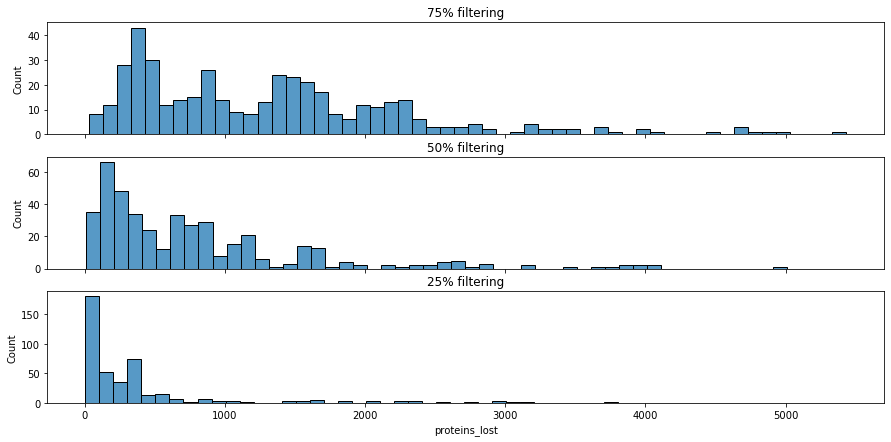

In [10]:
fig, ax = plt.subplots(3, sharex = "all",figsize = (15,7))
ax[0].set_title("75% filtering")
ax[1].set_title("50% filtering")
ax[2].set_title("25% filtering")
sns.histplot(filtered75_local.deletions_per_sample.proteins_lost, ax=ax[0], binwidth = 100)
sns.histplot(filtered50_local.deletions_per_sample.proteins_lost, ax=ax[1], binwidth = 100)
sns.histplot(filtered25_local.deletions_per_sample.proteins_lost, ax=ax[2], binwidth = 100)

In [14]:
models = {
    "svm": SVC(class_weight=new_weights),
    "rf": RandomForestClassifier(class_weight=new_weights),
    "lr": LogisticRegression(class_weight=new_weights)
}

In [15]:
filtered50_local.initialize_models(models)

Models initialized.
Models: dict_keys(['svm', 'rf', 'lr'])


In [16]:
filtered50_local.compare_models("init", StratifiedKFold(10), "f50_local_skf_weighted")

Comparing results done. See the results in results/comparison_f50_local_skf_weighted.csv
Comparing results done. See the results in results/comparison_f50_local_skf_weighted.csv
Comparing results done. See the results in results/comparison_f50_local_skf_weighted.csv


In [17]:
pbKFold = AAF.ProjectBasedSplit(10, filtered50_local.metadata, "tissue_type")

In [18]:
filtered50_local.compare_models("init", pbKFold, "f50_local_pbs_weighted")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50_local_pbs_weighted.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50_local_pbs_weighted.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50_local_pbs_weighted.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [7]:
base_model_class.set_labels('tissue_type')

In [10]:
base_model_class.filter_dataset(method = "reoccur global", percentage_reoccurence= .75)

Filtered dataset on reoccur global stored in 'filtered_dataset'


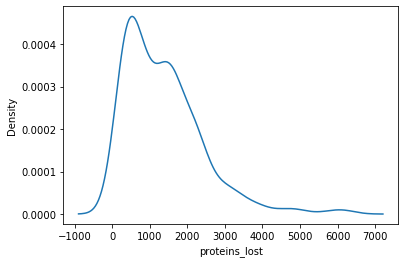

In [13]:
sns.kdeplot(base_model_class.deletions_per_sample.proteins_lost)

In [9]:
base_model_class.filter_dataset(method = 'reoccur local', percentage_reoccurence=.75)

Filtered dataset on reoccur local stored in 'filtered_dataset'


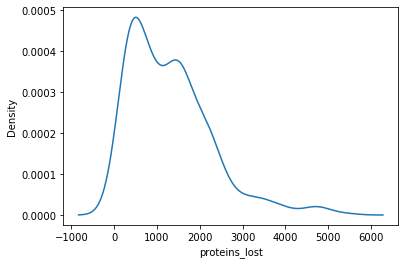

In [10]:
sns.kdeplot(base_model_class.deletions_per_sample.proteins_lost)

### Exploration

In [147]:
print(labels.value_counts().values)
total = sum(labels.value_counts().values)
print(labels.value_counts().index.values)

[83 74 63 49 48 47 28 26 26 20 18 11  4  4  4  4  1]
['breast' 'blood' 'brain' 'ovary' '/' 'cervix' 'umbilical vein' 'colon'
 'skin' 'kidney' 'trophoblast' 'liver' 'prostate' 'fetal kidney'
 'fibroblast' 'lung' 'T-cell']


In [142]:
labels.value_counts()/total *100

breast            16.274510
blood             14.705882
brain             12.352941
ovary              9.607843
cervix             9.215686
umbilical vein     5.490196
colon              5.098039
skin               5.098039
kidney             3.921569
liver              2.156863
Name: tissue_type, dtype: float64

In [134]:
labels.value_counts()

breast            83
blood             75
brain             63
ovary             49
cervix            47
umbilical vein    28
colon             26
skin              26
kidney            20
liver             11
Name: tissue_type, dtype: int64

In [137]:
labels.value_counts().values

array([83, 75, 63, 49, 47, 28, 26, 26, 20, 11])

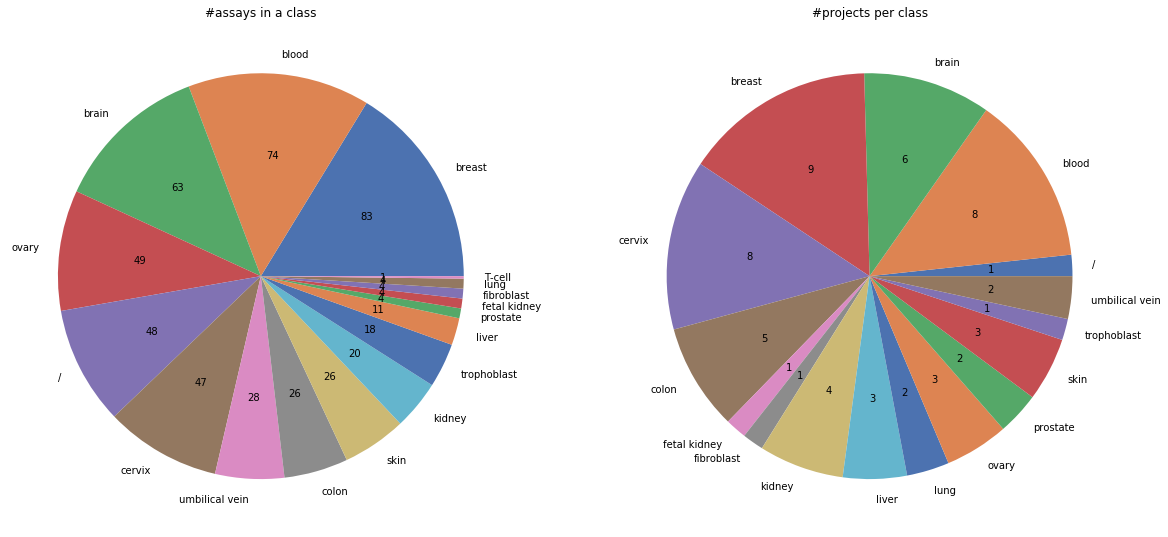

In [149]:
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title("#assays in a class")
fig.set_facecolor('white')
_ = plt.pie(labels.value_counts().values, labels = labels.value_counts().index.values, colors = sns.color_palette("deep", n_colors=len(labels.value_counts().values)), 
autopct= lambda p: '{:.0f}'.format(p*total/100))

plt.subplot(122)
pxd_classes = metadata.groupby('tissue_type').nunique().PXD_accession
plt.title(r"#projects per class")
_ = plt.pie(pxd_classes.values, labels = pxd_classes.index.values, colors = sns.color_palette("deep", n_colors=len(labels.value_counts().values)),
autopct = lambda p: '{:.0f}'.format(p*sum(pxd_classes.values)/100))

In [132]:
pxd_classes.values

array([1, 8, 6, 9, 8, 5, 1, 1, 4, 3, 2, 3, 2, 3, 1, 2])

In [131]:
pxd_classes.index.values

array(['/', 'blood', 'brain', 'breast', 'cervix', 'colon', 'fetal kidney',
       'fibroblast', 'kidney', 'liver', 'lung', 'ovary', 'prostate',
       'skin', 'trophoblast', 'umbilical vein'], dtype=object)

---

### Models setup

In [ ]:
# Models to be used:

lr = LogisticRegression()
svc = SVC()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()
models = (lr, svc, rf, xgb)

# Parameter grids

lr_grid = {"penalty" : ['l2'],
            "class_weight": ["balanced"],
            "C": np.linspace(0.005, 5, 5)}

svc_grid = {'decision_function_shape': ["ovr"],
            "kernel": ['linear', 'poly', 'rbf'],
            "C": np.linspace(0.005, 5, 5),
            "class_weight": [weights]}

rf_grid = {'n_estimators': np.linspace(10, 200, 4, dtype = int),
            "criterion": ["gini", "entropy"], 
            "class_weight": [weights]}

ada_grid = {'n_estimators': np.linspace(10, 150, 4, dtype = int),
            'base_estimator': [DecisionTreeClassifier(max_depth=3, class_weight=weights)],
            "learning_rate": np.linspace(0.005, 5, 5)}

xgb_grid = {"verbosity": [0],
            'eta': np.linspace(0.005,0.5,5),
            'gamma': np.linspace(0.005,10,5),
            'max_depth': [3,5,7,10]}

grids = (lr_grid, svc_grid, rf_grid, xgb_grid)

In [39]:
# Outerloop loops 10 times doing 9:1 train test split
skf = StratifiedKFold(10) 
best_parameters = {}
model_names = ["lr","svc", "rf", "xgb"]
cms = {}
f1_scores = {}
all_results_df = pd.DataFrame()

In [18]:
list(weights.keys())

['breast',
 'blood',
 'brain',
 'ovary',
 'cervix',
 'umbilical vein',
 'colon',
 'skin',
 'kidney',
 'trophoblast',
 'liver']

## Modelling without feature selection, filtering or special train test split

In [67]:
skf = StratifiedKFold(5)

In [71]:
data

,A0A024RBG1,A0A075B6X5,A0A096LP01,A0A096LP49,A0A0A6YYK6,A0A0B4J1V0,A0A0B4J2F0,A0A0J9YWL9,A0A0J9YX94,A0A0U1RRE5,...,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,Q9Y6Z7,W5XKT8
0,0.000010,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000070,0.000016,0.000028,0.000040,0.000062,0.000000,0.000088,0.000000,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000068,0.000016,0.000033,0.000042,0.000045,0.000001,0.000075,0.000000,0.0,0.0
2,0.000011,0.0,0.000061,0.0,0.0,0.000016,0.000000,0.000002,0.0,0.0,...,0.000000,0.000000,0.000007,0.000024,0.000045,0.000000,0.000092,0.000024,0.0,0.0
3,0.000011,0.0,0.000080,0.0,0.0,0.000016,0.000000,0.000002,0.0,0.0,...,0.000000,0.000000,0.000005,0.000035,0.000033,0.000000,0.000076,0.000024,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000350,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000018,0.000020,0.000161,0.000143,0.000000,0.000441,0.000000,0.0,0.0
506,0.000189,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000124,0.000107,0.000000,0.000291,0.000000,0.0,0.0
507,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000270,0.000279,0.000024,0.000000,0.000389,0.000000,0.0,0.0
508,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000169,0.000000,0.0,0.0,...,0.000000,0.000000,0.000054,0.000018,0.000000,0.000000,0.000027,0.000000,0.0,0.0


In [11]:
metadata.columns

Index(['assay_id', 'tissue_type', 'PXD_accession'], dtype='object')

In [61]:
import random
class ProjectBasedSplit():
    def __init__(self, splits: int, metadata: pd.DataFrame, on = str):
        """Called when training model and splitting_procedure is set as 'project'
        
        metadata: the metadata table that is used to generate splits
        
        on: the column name that represent the labels"""

        self.splits = splits
        self.metadata = metadata
        self.label = on
        self.dropped_pxds = []

    def split(self, dataset, metadata, groups = None):
        """Generate indices to split dataset into training and test set

        metadata should be a dataframe containing following columns:
            - PXD_accession
            - assay_id (unique)
            - label (given when initiating this splitting class)
        
        Splits are done with complete projects
        
        No unique splits are ensured.
        
        returns list of sets containing (train_index, test_index)"""
        
        metadata = self.metadata.loc[self.metadata.index.isin(dataset.index),:]

        index_splits = []
        for split in range(self.splits):
            train_index, test_index, dropped_pxds = self.train_test_project_split(dataset, metadata=metadata)
            index_splits.append((train_index, test_index))
            self.dropped_pxds.append(dropped_pxds)

            yield train_index, test_index
        
    def train_test_project_split(self, dataset, metadata: pd.DataFrame, groups = None):

        self.metadata = metadata
        pxds = metadata.PXD_accession.unique()
        n_samples = len(dataset)
        random.shuffle(pxds)
        dropped_pxds = []
        indeces = np.array([],dtype = int)

        for pxd in pxds:
            
            pxd_indeces = np.concatenate((self.metadata.loc[self.metadata.PXD_accession == pxd,:].index.to_numpy(), indeces))
            counter = self.metadata.iloc[~self.metadata.index.isin(pxd_indeces),:].groupby(self.label).nunique()
            assays = len(pxd_indeces)

            condition1 = (assays/n_samples) < 0.1 # Ensure no more than 10% of data in testset
            condition2 = not False in (counter.PXD_accession > 1).unique() # Ensure at least 2 projects per class
            condition3 = not False in (counter.assay_id > 10).unique() # Ensure > 10 samples per class for cv

            if condition1 and condition2 and condition3:
                dropped_pxds.append(pxd)
                indeces = pxd_indeces

        classes_in_test = self.metadata[self.metadata.PXD_accession.isin(dropped_pxds)][self.label].unique()
        #if the resulting test train split contains at most 4 projects and represents at most 3 classes, try again
        if len(dropped_pxds)<5 and len(classes_in_test) < 4:
            return self.train_test_project_split(dataset = dataset, metadata=metadata)

        train_index = dataset.iloc[~dataset.index.isin(indeces), :].index.to_numpy()
        test_index = indeces 

        return train_index, test_index, dropped_pxds   

    def get_n_splits(self, x, y, groups = None):
        return self.splits

In [40]:
grid_test = GridSearchCV(LogisticRegression(),lr_grid,cv = skf)
grid_test.fit(data, labels)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': array([0.005  , 1.25375, 2.5025 , 3.75125, 5.     ]),
                         'class_weight': ['balanced'], 'penalty': ['l2']})

In [37]:
# Outerloop loops 10 times doing 9:1 train test split
skf = StratifiedKFold(10) 
flag = True

for i in range(0,5):
    
    model_name = model_names[i]
    
    clf = models[i]
    grid = grids[i]

    outerloop_count = 0
    print(f"Start evaluation {model_name}")
    for train, test in skf.split(data, labels):
        
        outerloop_count += 1
        print(f"CV: {outerloop_count}/10")

        X_train = data.iloc[train,:]
        Y_train = labels.iloc[train]
        X_test = data.iloc[test,:]
        Y_test = labels.iloc[test]
        
        # Gridsearch
        gridsearch = GridSearchCV(clf, param_grid = grid, scoring = 'f1_weighted', cv = 5)
        gridsearch.fit(X_train, Y_train)
        
        Y_pred = gridsearch.predict(X_test)
        
        # Store confusion matrix and f1-score after each outerloop
        f1_score_ = f1_score(Y_test, Y_pred, average = None, labels = list(weights.keys()))

        cm = confusion_matrix(Y_test, Y_pred, labels = gridsearch.classes_)
 
        best_parameters[outerloop_count] = [gridsearch.best_params_]
        f1_scores[outerloop_count] = [f1_score_]
        cms[outerloop_count] = [cm]

    parameter_df = pd.DataFrame(best_parameters)
    f1_scores_df = pd.DataFrame(f1_scores)
    cms_df = pd.DataFrame(cms)

    model_results_df = pd.concat([parameter_df.rename({0:"parameter"}), f1_scores_df.rename({0:"f1"}), cms_df.rename({0:"cms"})]).transpose().rename(index = {x: model_name for x in range(11)})
    all_results_df = pd.concat([model_results_df, all_results_df], axis = 0)
    
    all_results_df.to_csv("base_results.csv",sep = ";", index = True)



Start evaluation lr
CV: 1/10
CV: 2/10
CV: 3/10
CV: 4/10
CV: 5/10
CV: 6/10
CV: 7/10
CV: 8/10
CV: 9/10
CV: 10/10
Start evaluation svc
CV: 1/10
CV: 2/10
CV: 3/10
CV: 4/10
CV: 5/10
CV: 6/10
CV: 7/10
CV: 8/10
CV: 9/10
CV: 10/10
Start evaluation rf
CV: 1/10
CV: 2/10
CV: 3/10
CV: 4/10
CV: 5/10
CV: 6/10
CV: 7/10
CV: 8/10
CV: 9/10
CV: 10/10
Start evaluation xgb
CV: 1/10


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
500 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/xgboost/core.py", line 532, in inner_f
    return f(**kwargs)
  File "/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/xgboost/sklearn.py", line 1358, in fit
    f"In

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10], got ['blood' 'brain' 'breast' 'cervix' 'colon' 'kidney' 'liver' 'ovary' 'skin'
 'trophoblast' 'umbilical vein']

In [31]:
test = pd.concat([parameter_df.rename({0:"parameter"}), f1_scores_df.rename({0:"f1"}), cms_df.rename({0:"cms"})]).transpose().rename(index = {x: "lr" for x in range(11)})

---

## drop complete project as test set

The test set is a complete project. Because samples share more similarity within a project than between projects, this method should ensure that the test set represent a true unseen sample. 

In [8]:
import random

def train_test_project_split(dataset: pd.DataFrame, metadata: pd.DataFrame, log = False):
    """
    the split is done by ensuring 3 conditions:
    - the test set is < 10 % of the dataset
    - the train set must contain at least 2 projects
    - each class must contain > 10 samples
    
    returns X_train, Y_train, X_test, Y_test"""
    #print(metadata.tissue_type.value_counts())
    pxds = metadata.PXD_accession.unique()
    n_samples = len(dataset)
    random.shuffle(pxds)
    dropped_pxds = []
    indeces = []
    for pxd in pxds:

        pxd_indeces = metadata.loc[metadata.PXD_accession == pxd,:].index.tolist() + indeces
        counter =  metadata.iloc[~metadata.index.isin(pxd_indeces),:].groupby("tissue_type").nunique()
        assays = len(pxd_indeces)

        condition1 = (assays/n_samples) < 0.1 # Ensure no more than 10% of data in testset
        condition2 = not False in (counter.PXD_accession > 1).unique() # Ensure at least 2 projects per class
        condition3 = not False in (counter.assay_id > 10).unique() # Ensure > 10 samples per class for cv

        if log:
            print(f'''condition 1: {condition1}, {assays} {n_samples}
            condition 2: {condition2}, {(counter.PXD_accession > 1)}
            condition 3: {condition3}, {(counter.assay_id > 10).unique()}''')
        if condition1 and condition2 and condition3:
            dropped_pxds.append(pxd)
            indeces = pxd_indeces

    if len(dropped_pxds)<5 and len(metadata[metadata.PXD_accession.isin(dropped_pxds)].tissue_type.unique()) < 4:
        #if the resulting test train split contains at most 4 projects and represents at most 3 classes, try again
        return train_test_project_split(dataset = dataset, metadata = metadata)

    X_train = dataset.iloc[~dataset.index.isin(indeces), :]
    Y_train = metadata.iloc[~metadata.index.isin(indeces), 1]
    X_test = dataset.iloc[dataset.index.isin(indeces),:]
    Y_test = metadata.iloc[metadata.index.isin(indeces), 1]

    return X_train, Y_train, X_test, Y_test, dropped_pxds

In [9]:
metadata = metadata.iloc[metadata.index.isin(data.index),:]

1 /10


<Figure size 720x720 with 0 Axes>

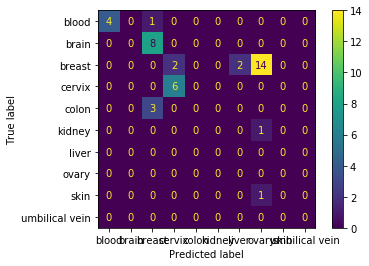

2 /10


<Figure size 720x720 with 0 Axes>

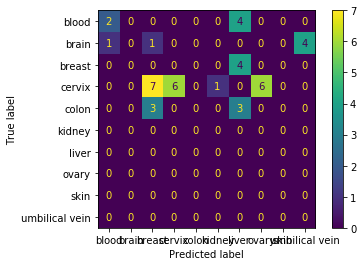

3 /10


<Figure size 720x720 with 0 Axes>

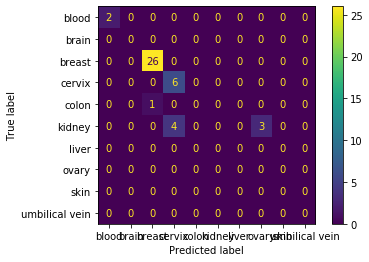

4 /10


<Figure size 720x720 with 0 Axes>

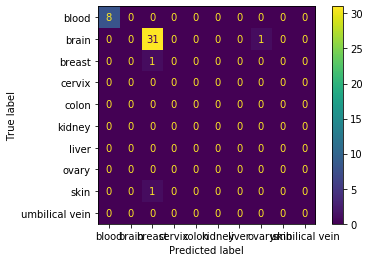

5 /10


<Figure size 720x720 with 0 Axes>

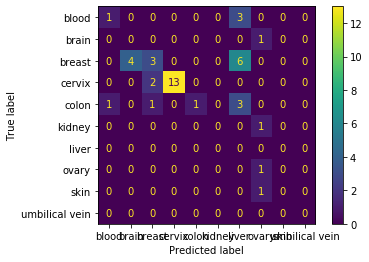

6 /10


<Figure size 720x720 with 0 Axes>

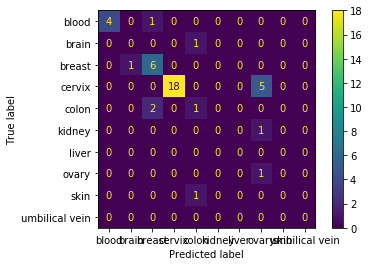

7 /10


<Figure size 720x720 with 0 Axes>

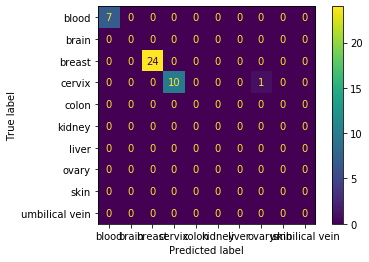

8 /10


<Figure size 720x720 with 0 Axes>

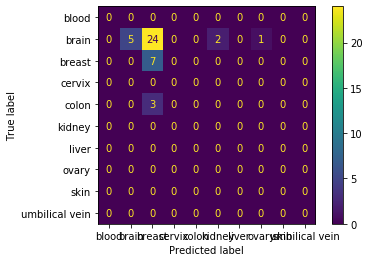

9 /10


<Figure size 720x720 with 0 Axes>

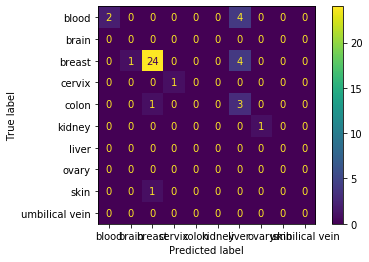

10 /10


<Figure size 720x720 with 0 Axes>

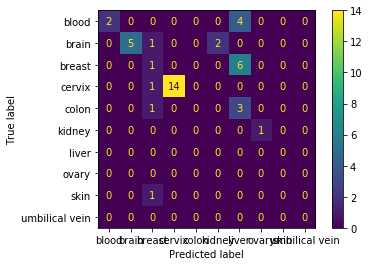

In [88]:
df_dropped_pxds = {}
f1_scores_ = []
for x in range(10):
    
    print(x+1,"/10")
    X_train, Y_train, X_test, Y_test, dropped_pxds = train_test_project_split(data, metadata)
    df_dropped_pxds[x] = dropped_pxds

    clf = RandomForestClassifier(class_weight=weights, n_estimators=150)

    gridsearch = GridSearchCV(clf, param_grid = rf_grid, scoring = 'f1_weighted', cv = 10)
    gridsearch.fit(X_train, Y_train)
            
    Y_pred = gridsearch.predict(X_test)
            
    # Store confusion matrix and f1-score after each outerloop
    f1_scores_.append(f1_score(Y_test, Y_pred, average = "micro"))

    cm = confusion_matrix(Y_test, Y_pred, labels = gridsearch.classes_)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=gridsearch.classes_)
    
    plt.figure(figsize = (10,10))
    disp.plot()
    plt.show()

### TODO: improvement for F1-score: instead of #samples, set percentage of samples in a project that are right or wrongly predicted

In [90]:
f1_scores_

[0.23809523809523808,
 0.19047619047619047,
 0.8095238095238095,
 0.21428571428571427,
 0.4523809523809524,
 0.7142857142857143,
 0.9761904761904762,
 0.2857142857142857,
 0.6428571428571429,
 0.5238095238095238]

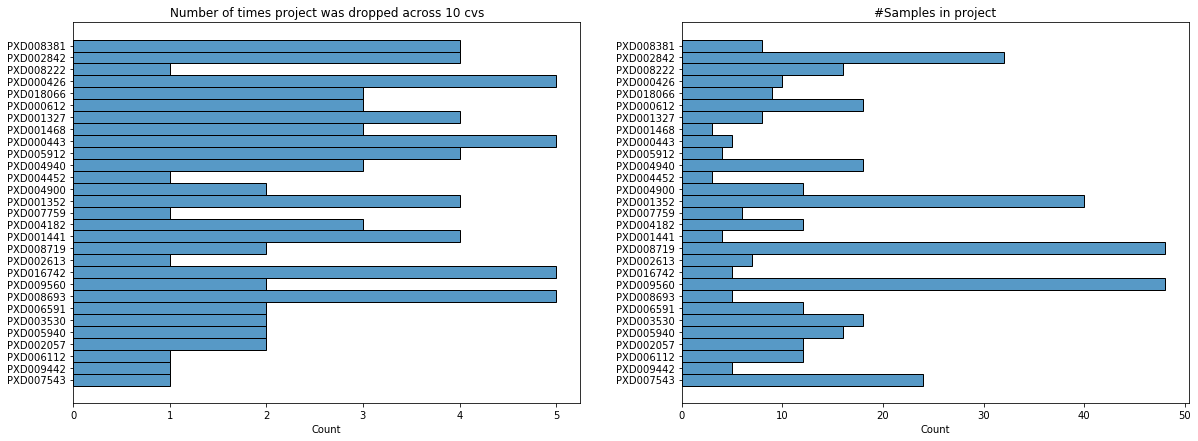

In [91]:
# Frequency of choosing certain pxd as testset and the amount of samples in it
pxds = []
for list_pxd in df_dropped_pxds.values():
    for pxd in list_pxd:
        pxds.append(pxd)


plt.figure(figsize = (20,7))
plt.subplot(121)
plt.title("Number of times project was dropped across 10 cvs")
sns.histplot(y=pxds)

sample_amount = []
for x in pxds:
    sample_amount += metadata[metadata.PXD_accession == x].PXD_accession.tolist()

plt.subplot(122)
plt.title("#Samples in project")
sns.histplot(y = sample_amount)

## filtering reoccuring proteins (75%) with project as test set

In [99]:
data_75_filtered = pd.read_csv("filtered_75_ML_dataset.csv") # From 'evaluation_filtering_techniques.ipynb'
data_75_filtered.fillna(0, inplace = True)
data_75_filtered = data_75_filtered.iloc[data_75_filtered.index.isin(data.index)]

In [100]:
print(data_75_filtered.shape, metadata.shape)

(428, 7319) (428, 3)


In [101]:
data_75_filtered.head()

,A0A0B4J2F0,A0A0U1RRI6,A0A0U1RRL7,A0A576,A0AV96,A0AVT1,A0FGR8,A0JNW5,A0MZ66,A0PJW6,...,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
0,0.0,0.0,0.0,0.0,0.000128,0.000284,0.000035,0.000027,0.000157,0.000009,...,0.000052,0.000058,0.000025,0.000038,0.0,0.0,0.0,0.000040,0.0,0.000088
1,0.0,0.0,0.0,0.0,0.000123,0.000267,0.000026,0.000029,0.000150,0.000018,...,0.000068,0.000065,0.000026,0.000033,0.0,0.0,0.0,0.000042,0.0,0.000075
2,0.0,0.0,0.0,0.0,0.000143,0.000190,0.000115,0.000024,0.000119,0.000010,...,0.000064,0.000009,0.000039,0.000019,0.0,0.0,0.0,0.000024,0.0,0.000092
3,0.0,0.0,0.0,0.0,0.000142,0.000200,0.000104,0.000016,0.000106,0.000009,...,0.000067,0.000009,0.000050,0.000031,0.0,0.0,0.0,0.000035,0.0,0.000076
4,0.0,0.0,0.0,0.0,0.000000,0.000333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000704,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000350


1 /10


<Figure size 720x720 with 0 Axes>

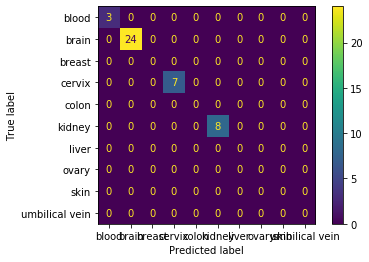

2 /10


<Figure size 720x720 with 0 Axes>

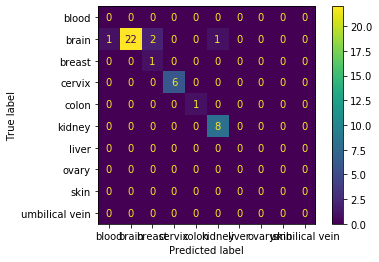

3 /10


<Figure size 720x720 with 0 Axes>

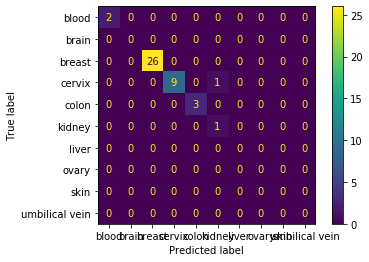

4 /10


<Figure size 720x720 with 0 Axes>

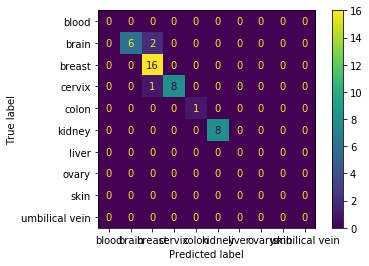

5 /10


<Figure size 720x720 with 0 Axes>

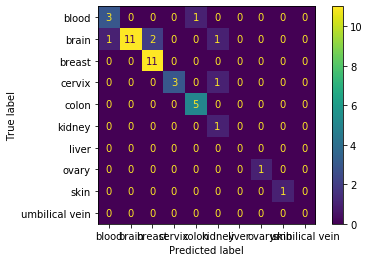

6 /10


<Figure size 720x720 with 0 Axes>

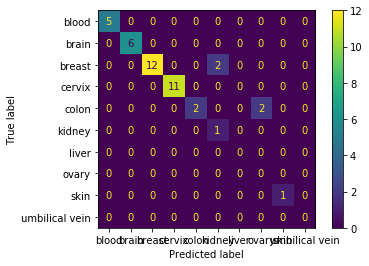

7 /10


<Figure size 720x720 with 0 Axes>

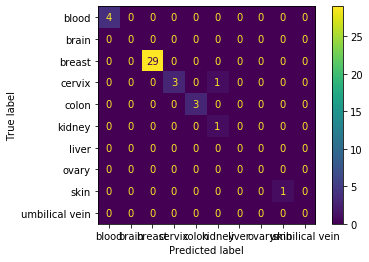

8 /10


<Figure size 720x720 with 0 Axes>

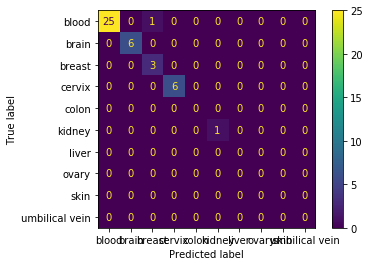

9 /10


<Figure size 720x720 with 0 Axes>

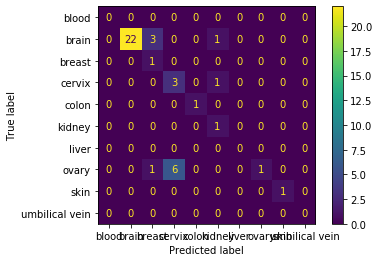

10 /10


<Figure size 720x720 with 0 Axes>

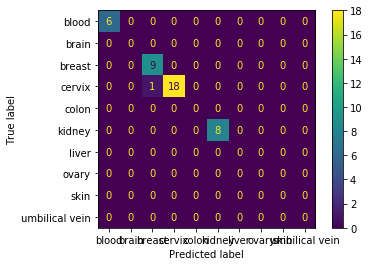

In [102]:
df_dropped_pxds = {}
f1_scores_filtered_ = []
for x in range(10):
    
    print(x+1,"/10")
    X_train, Y_train, X_test, Y_test, dropped_pxds = train_test_project_split(data_75_filtered, metadata)
    df_dropped_pxds[x] = dropped_pxds

    clf = RandomForestClassifier(class_weight=weights, n_estimators=150)

    gridsearch = GridSearchCV(clf, param_grid = rf_grid, scoring = 'f1_weighted', cv = 10)
    gridsearch.fit(X_train, Y_train)
            
    Y_pred = gridsearch.predict(X_test)
            
    # Store confusion matrix and f1-score after each outerloop
    f1_scores_filtered_.append(f1_score(Y_test, Y_pred, average = "micro"))

    cm = confusion_matrix(Y_test, Y_pred, labels = gridsearch.classes_)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=gridsearch.classes_)
    
    plt.figure(figsize = (10,10))
    disp.plot()
    plt.show()

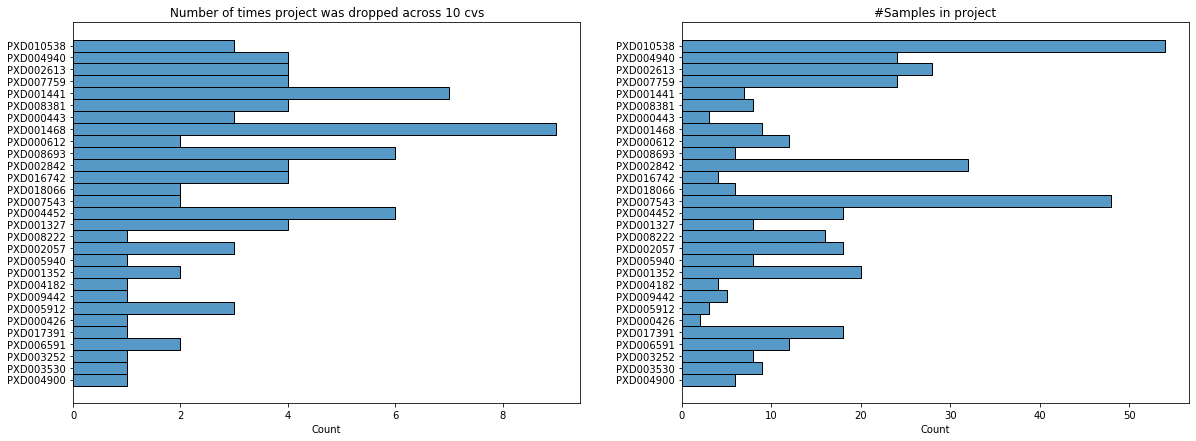

In [118]:
# Frequency of choosing certain pxd as testset and the amount of samples in it
pxds = []
for list_pxd in df_dropped_pxds.values():
    for pxd in list_pxd:
        pxds.append(pxd)


plt.figure(figsize = (20,7))
plt.subplot(121)
plt.title("Number of times project was dropped across 10 cvs")
sns.histplot(y=pxds)

sample_amount = []
for x in pxds:
    sample_amount += metadata[metadata.PXD_accession == x].PXD_accession.tolist()

plt.subplot(122)
plt.title("#Samples in project")
sns.histplot(y = sample_amount)

In [111]:
df_F1 = pd.concat([pd.DataFrame(data = {'f1': f1_scores_, 'type': "base"}), pd.DataFrame(data = {'f1': f1_scores_filtered_, 'type': "filtered_75"})], axis = 0)

In [113]:
df_F1

,f1,type
0,0.238095,base
1,0.190476,base
2,0.809524,base
3,0.214286,base
4,0.452381,base
5,0.714286,base
6,0.976190,base
7,0.285714,base
8,0.642857,base
9,0.523810,base


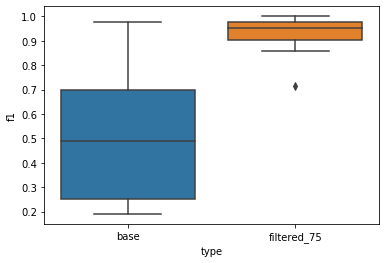

In [117]:
sns.boxplot(data=df_F1, x = "type", y = "f1", orient = "vertical")

In [34]:
test_indices = metadata[metadata.PXD_accession == "PXD004280"].index.tolist()

In [41]:
test_table=(data.iloc[test_indices, :] != 0).sum(axis = 1).sort_values(ascending = False)

In [108]:
def _identify_global_reoccured_proteins(subset: pd.DataFrame, percentage_reoccurence):
    '''Returns protein_ids that reoccur in >= percentage_reoccurence of the subset
    
    Also returns protein_ids that are filtered'''

    # Get percentage of samples a protein occurs in 
    reoccuring_proteins = (subset != 0).sum() / len(subset)

    # Get the proteins that do not meet the required percentage of occurence but are identified in at least 1 sample
    deleted_proteins = reoccuring_proteins[(reoccuring_proteins < percentage_reoccurence) & (reoccuring_proteins != 0)].index.tolist()

    # Get reoccuring proteins
    result = reoccuring_proteins[(reoccuring_proteins >= percentage_reoccurence) & (reoccuring_proteins != 0)].index.tolist()
    
    return result, deleted_proteins

def _identify_local_reoccured_proteins(subset: pd.DataFrame, percentage_reoccurence):
    # Sort the samples according to how much proteins were identified
    sorted_count_subset = subset.sum(axis = 1).sort_values(ascending = False)
    #Get the indices in that order
    indices = sorted_count_subset.index.tolist()

    filter_indices = []
    reoccuring_proteins = []
    deleted_proteins = []
    for index in indices:

        filter_indices = filter_indices + [index]
        
        # Only look at the samples most identified
        filter_subset = subset.iloc[filter_indices,:]
        
        # Get the proteins that are identified in the other samples that have less identifications
        less_quantified = subset.iloc[~subset.index.isin(filter_indices),:]
        less_quantified_proteins = (less_quantified != 0).sum(axis = 0)
        less_quantified_proteins = less_quantified_proteins[less_quantified_proteins != 0].index
        print(len(less_quantified_proteins))
        
        # Get proteins only present in the samples with most quantifications that occur in x percent or more of those samples
        proteins_to_keep, proteins_to_ignore = _identify_global_reoccured_proteins(filter_subset.loc[:,~subset.columns.isin(less_quantified_proteins)], percentage_reoccurence=percentage_reoccurence)
        reoccuring_proteins += proteins_to_keep
        deleted_proteins += proteins_to_ignore

        print(f"{filter_indices}\nreoccur: {len(proteins_to_keep)}\ndelete: {len(proteins_to_ignore)}")

    return reoccuring_proteins, deleted_proteins

In [12]:
data.columns[:15]

Index(['A0A024RBG1', 'A0A075B6X5', 'A0A096LP01', 'A0A096LP49', 'A0A0A6YYK6',
       'A0A0B4J1V0', 'A0A0B4J2F0', 'A0A0J9YWL9', 'A0A0J9YX94', 'A0A0U1RRE5',
       'A0A0U1RRI6', 'A0A0U1RRK4', 'A0A0U1RRL7', 'A0A1B0GTH6', 'A0A1B0GTR0'],
      dtype='object')

In [11]:
[x for x  in data.columns if x not in data.columns[:15]]

['A0A1B0GTY4',
 'A0A1B0GUS4',
 'A0A1B0GUU1',
 'A0A1B0GUW6',
 'A0A1B0GV03',
 'A0A1B0GV85',
 'A0A1B0GWB2',
 'A0A1W2PR82',
 'A0A2R8YFL7',
 'A0A576',
 'A0A5F9ZHS7',
 'A0AUZ9',
 'A0AV02',
 'A0AV96',
 'A0AVF1',
 'A0AVI4',
 'A0AVK6',
 'A0AVT1',
 'A0FGR8',
 'A0FGR9',
 'A0JLT2',
 'A0JNW5',
 'A0MZ66',
 'A0PJE2',
 'A0PJW6',
 'A0PJX4',
 'A0PJZ3',
 'A0PK00',
 'A1A4S6',
 'A1A5B4',
 'A1A5C7',
 'A1A5D9',
 'A1IGU5',
 'A1KXE4',
 'A1L020',
 'A1L0T0',
 'A1L167',
 'A1L170',
 'A1L188',
 'A1L390',
 'A1L4H1',
 'A1L4K1',
 'A1X283',
 'A2A288',
 'A2A2Y4',
 'A2A2Z9',
 'A2A3L6',
 'A2A3N6',
 'A2AJT9',
 'A2RRD8',
 'A2RRH5',
 'A2RRP1',
 'A2RTX5',
 'A2RTY3',
 'A2RU30',
 'A2RU49',
 'A2RU67',
 'A2RUB1',
 'A2RUB6',
 'A2RUC4',
 'A2RUH7',
 'A2RUS2',
 'A2VDF0',
 'A2VDJ0',
 'A2VEC9',
 'A3KMH1',
 'A3KN83',
 'A3QJZ6',
 'A4D0S4',
 'A4D126',
 'A4D161',
 'A4D1B5',
 'A4D1E1',
 'A4D1E9',
 'A4D1F6',
 'A4D1P6',
 'A4D1S0',
 'A4D1S5',
 'A4D1U4',
 'A4D263',
 'A4D2B0',
 'A4D2B8',
 'A4FU01',
 'A4FU49',
 'A4FU69',
 'A4QN01',
 'A4UGR9',
 'A

In [113]:
(data != 0).sum(axis = 1)

0      8127
1      8111
2      8065
3      8001
4      1320
       ... 
505    3345
506    3767
507    3472
508    3014
509    2148
Length: 428, dtype: int64

In [135]:
reoccur, deleted = _identify_local_reoccured_proteins(data.iloc[list(range(5)),:], .75) 

9667
[0]
reoccur: 371
delete: 0
9305
[0, 2]
reoccur: 48
delete: 685
8061
[0, 2, 1]
reoccur: 199
delete: 1778
1320
[0, 2, 1, 3]
reoccur: 5947
delete: 2771
0
[0, 2, 1, 3, 4]
reoccur: 6455
delete: 3583


In [133]:
metadata[metadata.assay_id == 31355]

,assay_id,tissue_type,PXD_accession


In [136]:
len(set(reoccur))

7613

In [118]:
(data.iloc[list(range(4)),:] != 0).sum(axis = 0)[(data.iloc[list(range(4)),:] != 0).sum(axis = 0) != 0]

A0A024RBG1    3
A0A096LP01    2
A0A0B4J1V0    2
A0A0J9YWL9    2
A0A0U1RRI6    1
             ..
Q9Y6X9        4
Q9Y6Y0        4
Q9Y6Y1        1
Q9Y6Y8        4
Q9Y6Y9        2
Length: 10003, dtype: int64

In [137]:
len(set(deleted))

3583

In [119]:
count = 0
for x in set(deleted):
    if x in set(reoccur):
        count += 1

In [120]:
count

625

In [78]:
(data != 0).sum(axis = 1)

0      8127
1      8111
2      8065
3      8001
4      1320
       ... 
505    3345
506    3767
507    3472
508    3014
509    2148
Length: 428, dtype: int64

In [81]:
len(deleted)

24565

In [48]:
for index, amount in zip(test_table.index, test_table):
    print(index, amount)

20 1539
18 1535
24 1520
21 1505
33 1502
32 1495
19 1488
15 1484
9 1449
38 1448
22 1425
8 1421
25 1419
11 1417
7 1416
16 1410
14 1409
31 1409
6 1408
34 1399
17 1399
23 1397
10 1386
13 1376
30 1376
5 1361
39 1340
4 1320
12 1310
43 1301
35 1294
37 1259
26 1255
27 1252
36 1242
40 1201
41 1187
28 1185
44 1156
29 1148
45 1105
42 950


In [123]:
test_clf = RandomForestClassifier(class_weight=weights, n_estimators=150)
test_clf.fit(data_75_filtered, metadata.tissue_type)

RandomForestClassifier(class_weight={'blood': 4.706666666666667,
                                     'brain': 5.7936507936507935,
                                     'breast': 4.156626506024097,
                                     'cervix': 8.106382978723405,
                                     'colon': 15.461538461538462,
                                     'kidney': 20.4, 'liver': 37.90909090909091,
                                     'ovary': 7.73469387755102,
                                     'skin': 15.461538461538462,
                                     'umbilical vein': 14.285714285714286},
                       n_estimators=150)